# Financial Transactions 

Data Source: https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets/data

This data source has five data files: 
- cards_data.csv
- transactions_data.csv
- users_data.csv
- mcc_codes.json
- train_fraud_labels.json

The objective of this project is to understand common characteristics of fraudulent transactions.

Maybe:
predictive model to accurately identify potentially fraudulent transactions in real time


## Step 1: Load Data

### Loading Data

In [4]:
#Import libraries 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import json
import seaborn as sns
from tabulate import tabulate

# Load all csv files into Pandas DataFrame
cards_df = pd.read_csv("cards_data.csv") 
trans_df = pd.read_csv("transactions_data.csv")
users_df = pd.read_csv("users_data.csv")

# Loading merchant category codes as pandas DataFrame
with open('mcc_codes.json', 'r') as file:
    mcc_data = json.load(file)  # Load the JSON data into a Python object

mcc_data_list =[]
for key, value in mcc_data.items():
    entry = {"mcc" : key, "Name": value}
    mcc_data_list.append(entry)

# Normalize the loaded JSON data into a DataFrame
mcc_df = pd.DataFrame(mcc_data_list)

## Load fraud labels as pandas DataFrame
with open('train_fraud_labels.json', 'r') as file:
    tfl_data = json.load(file)  # Load the JSON data into a Python object

tfl_data_list =[]
for key, value in tfl_data['target'].items():
    entry = {"id" : key, "fraud": value}
    tfl_data_list.append(entry)

# Normalize the loaded JSON data into a DataFrame
tfl_df = pd.DataFrame(tfl_data_list)

In [5]:
print("\n Transaction data ---------------------------------------")
print(trans_df.shape)
print(trans_df.dtypes)
print("\n Cards data ----------------------------------------------")
print(cards_df.shape)
print(cards_df.dtypes)
print("\n Users data ---------------------------------------------")
print(users_df.shape)
print(users_df.dtypes)
print("\n Merchant category code data ----------------------------")
print(mcc_df.shape)
print(mcc_df.dtypes)
print("\n Transaction fraud labels data --------------------------")
print(tfl_df.shape)
print(tfl_df.dtypes)


 Transaction data ---------------------------------------
(13305915, 12)
id                  int64
date               object
client_id           int64
card_id             int64
amount             object
use_chip           object
merchant_id         int64
merchant_city      object
merchant_state     object
zip               float64
mcc                 int64
errors             object
dtype: object

 Cards data ----------------------------------------------
(6146, 13)
id                        int64
client_id                 int64
card_brand               object
card_type                object
card_number               int64
expires                  object
cvv                       int64
has_chip                 object
num_cards_issued          int64
credit_limit             object
acct_open_date           object
year_pin_last_changed     int64
card_on_dark_web         object
dtype: object

 Users data ---------------------------------------------
(2000, 14)
id                     int64


## Step 2: Data Cleansing

### Convert Data types

In [8]:
# Convert objects to int64, floats, or dates
# transaction data
trans_df['date'] = pd.to_datetime(trans_df['date'])
trans_df['amount'] = trans_df['amount'].replace({r'[^\d.-]': ''}, regex=True)
trans_df['amount'] = trans_df['amount'].astype(float)

# card data
cards_df['has_chip_binary'] = cards_df['has_chip'].map({'YES': 1, 'NO': 0})
cards_df['expires'] = pd.to_datetime(cards_df['expires'], format='%m/%d/%Y', errors='coerce')
cards_df['acct_open_date'] = pd.to_datetime(cards_df['acct_open_date'], format='%m/%d/%Y', errors='coerce')
cards_df['credit_limit'] = cards_df['credit_limit'].replace({r'[^\d.-]': ''}, regex=True)
cards_df['credit_limit'] = cards_df['credit_limit'].astype(float)
cards_df['card_on_dark_web'] = cards_df['card_on_dark_web'].map({'YES': 1, 'NO': 0})

# user data
users_df['gender_binary'] = users_df['gender'].map({'Male': 1, 'Female': 0})

users_df['per_capita_income'] = users_df['per_capita_income'].replace({r'[^\d.-]': ''}, regex=True)
users_df['per_capita_income'] = users_df['per_capita_income'].astype(float)

users_df['yearly_income'] = users_df['yearly_income'].replace({r'[^\d.-]': ''}, regex=True)
users_df['yearly_income'] = users_df['yearly_income'].astype(float)

users_df['total_debt'] = users_df['total_debt'].replace({r'[^\d.-]': ''}, regex=True)
users_df['total_debt'] = users_df['total_debt'].astype(float)

# merchant data and fraud label cata
mcc_df['mcc'] = mcc_df['mcc'].astype(int)
tfl_df['id'] = tfl_df['id'].astype(int)

### Merge Datasets

In [10]:
# Merge transaction data with fraud label data
trans_fraud = pd.merge(trans_df, tfl_df, on = "id", how = "inner")
trans_fraud['fraud_binary'] = trans_fraud['fraud'].map({'Yes': 1, 'No': 0})

# Merge merchant information with transaction data (tfm = transaction, fraud, merchant) 
tfm = pd.merge(trans_fraud, mcc_df, on = "mcc", how = "left")
# Merge card information with users dataframe
card_user = pd.merge(cards_df, users_df, left_on = "client_id", right_on = "id", how = "left", suffixes=("_cards", "_users"))
# Combined transaction, fraud, merchant, card, user info
tfmcu = pd.merge(tfm, card_user, left_on = "card_id", right_on = "id_cards", how = "left")

### Engineering new categories from available data

In [12]:
# Replace zeros in denominator columns with NaN
# Replace zeros in denominator columns with NaN without inplace
tfmcu["credit_limit"] = tfmcu["credit_limit"].replace(0, np.nan)
tfmcu["total_debt"] = tfmcu["total_debt"].replace(0, np.nan)
tfmcu["credit_score"] = tfmcu["credit_score"].replace(0, np.nan)
tfmcu["per_capita_income"] = tfmcu["per_capita_income"].replace(0, np.nan)

## Selecting, transforming, and creating relevant input variables (features) from raw data
tfmcu["ratio_amount_to_credit_limit"] = tfmcu["amount"] / tfmcu["credit_limit"]
tfmcu["ratio_amount_to_total_debt"] = tfmcu["amount"] / tfmcu["total_debt"]
tfmcu["ratio_amount_to_credit_score"] = tfmcu["amount"] / tfmcu["credit_score"]
tfmcu["ratio_credit_limit_to_total_debt"] = tfmcu["credit_limit"] / tfmcu["total_debt"]
tfmcu["ratio_income_to_capita_income"] = tfmcu["yearly_income"] / tfmcu["per_capita_income"]

tfmcu.head(5)

,id,date,client_id_x,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,yearly_income,total_debt,credit_score,num_credit_cards,gender_binary,ratio_amount_to_credit_limit,ratio_amount_to_total_debt,ratio_amount_to_credit_score,ratio_credit_limit_to_total_debt,ratio_income_to_capita_income
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,48277.0,110153.0,740,4,0,-1.400000,-0.000699,-0.104054,0.000499,2.038811
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,36853.0,112139.0,834,5,1,0.001601,0.000130,0.017470,0.081149,2.038781
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,34449.0,36540.0,686,3,1,0.005405,0.002189,0.116618,0.405090,2.039126
3,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,68362.0,96182.0,711,2,1,0.002428,0.000483,0.065274,0.198717,2.038892
4,7475333,2010-01-01 00:07:00,1807,165,4.81,Swipe Transaction,20519,Bronx,NY,10464.0,...,52065.0,98613.0,828,5,0,0.054045,0.000049,0.005809,0.000903,2.038806


In [13]:
### Data Profile - Summary Statistics 

# create a subset of the data
tfmcu_sub = tfmcu[['amount', 'merchant_id', 'mcc',
       'fraud_binary', 'has_chip_binary',
       'num_cards_issued', 'credit_limit',
       'year_pin_last_changed', 'current_age',
       'retirement_age', 'birth_year', 'gender_binary', 'per_capita_income', 'yearly_income',
       'total_debt', 'credit_score', 'num_credit_cards',
       'ratio_amount_to_credit_limit', 'ratio_amount_to_total_debt',
       'ratio_amount_to_credit_score', 'ratio_credit_limit_to_total_debt',
       'ratio_income_to_capita_income'
       ]]

#Summary Statistics 
summary_statistics = tfmcu_sub.describe().T
styled_table = summary_statistics.style.format(precision=2).set_table_styles(
    [
        {'selector': 'thead th', 'props': [('background-color', '#f0f0f0'), ('color', '#333'), ('font-weight', 'bold')]},
        {'selector': 'tbody td', 'props': [('border', '1px solid #ddd')]}
    ]
)
styled_table


,count,mean,std,min,25%,50%,75%,max
amount,8914963.00,42.95,81.53,-500.00,8.93,28.99,63.68,6613.44
merchant_id,8914963.00,47725.66,25816.23,1.00,25887.00,45926.00,67570.00,100342.00
mcc,8914963.00,5565.10,875.51,1711.00,5300.00,5499.00,5812.00,9402.00
fraud_binary,8914963.00,0.00,0.04,0.00,0.00,0.00,0.00,1.00
has_chip_binary,8914963.00,0.90,0.30,0.00,1.00,1.00,1.00,1.00
num_cards_issued,8914963.00,1.52,0.52,1.00,1.00,2.00,2.00,3.00
credit_limit,8879274.00,15612.09,12166.41,1.00,8200.00,13500.00,20859.00,141391.00
year_pin_last_changed,8914963.00,2011.34,2.89,2002.00,2010.00,2011.00,2013.00,2020.00
current_age,8914963.00,54.02,15.72,23.00,42.00,52.00,63.00,101.00
retirement_age,8914963.00,66.49,3.59,53.00,65.00,66.00,68.00,79.00


In [14]:
# Export to Excel
tfmcu.to_csv('output.csv', index=False)

## Step 3: Exploratory Data Analysis (EDA)

### Percent of Fraudulent Activities

In [17]:
print("Total number of fraudulent transactions is ", tfmcu["fraud_binary"].sum() , '.')
print(f"The percent of fraudulent transactions is {tfmcu["fraud_binary"].mean() *100:.2f}%")

Total number of fraudulent transactions is  13332 .
The percent of fraudulent transactions is 0.15%


### Fraudulent Activities over Time

In [19]:
#Group number of frad events per day, month, year 
tfmcu['date'] = tfmcu['date'].dt.date
tfmcu['month'] = pd.to_datetime(tfmcu['date']).dt.to_period('M')
tfmcu['year'] = pd.to_datetime(tfmcu['date']).dt.to_period('Y')

tfmcu_day = tfmcu.groupby("date").size().reset_index(name = "fraud count")
tfmcu_month = tfmcu.groupby("month").size().reset_index(name = "fraud count")
tfmcu_year = tfmcu.groupby("year").size().reset_index(name = "fraud count")

tfmcu_month['month'] = tfmcu_month['month'].astype(str)
tfmcu_year['year'] = tfmcu_year['year'].astype(str)

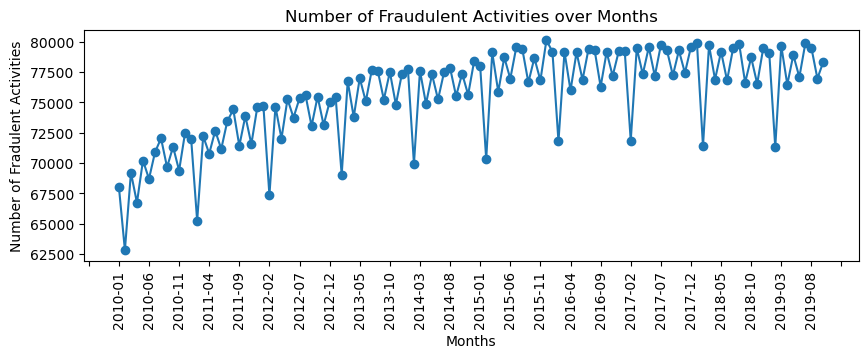

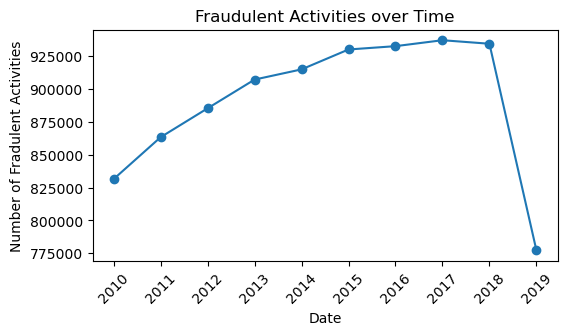

In [20]:
plt.figure(figsize=(10, 3))
plt.plot(tfmcu_month['month'],tfmcu_month['fraud count'], marker='o', linestyle='-')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune='both', nbins=30))
plt.title("Number of Fraudulent Activities over Months")
plt.xlabel("Months")
plt.ylabel("Number of Fradulent Activities")
plt.xticks(rotation=90)
plt.show()

plt.figure(figsize=(6, 3))
plt.plot(tfmcu_year['year'],tfmcu_year['fraud count'], marker='o', linestyle='-')
plt.title("Fraudulent Activities over Time")
plt.xlabel("Date")
plt.ylabel("Number of Fradulent Activities")
plt.xticks(rotation=45)
plt.show()

### Categorical Bar Plots

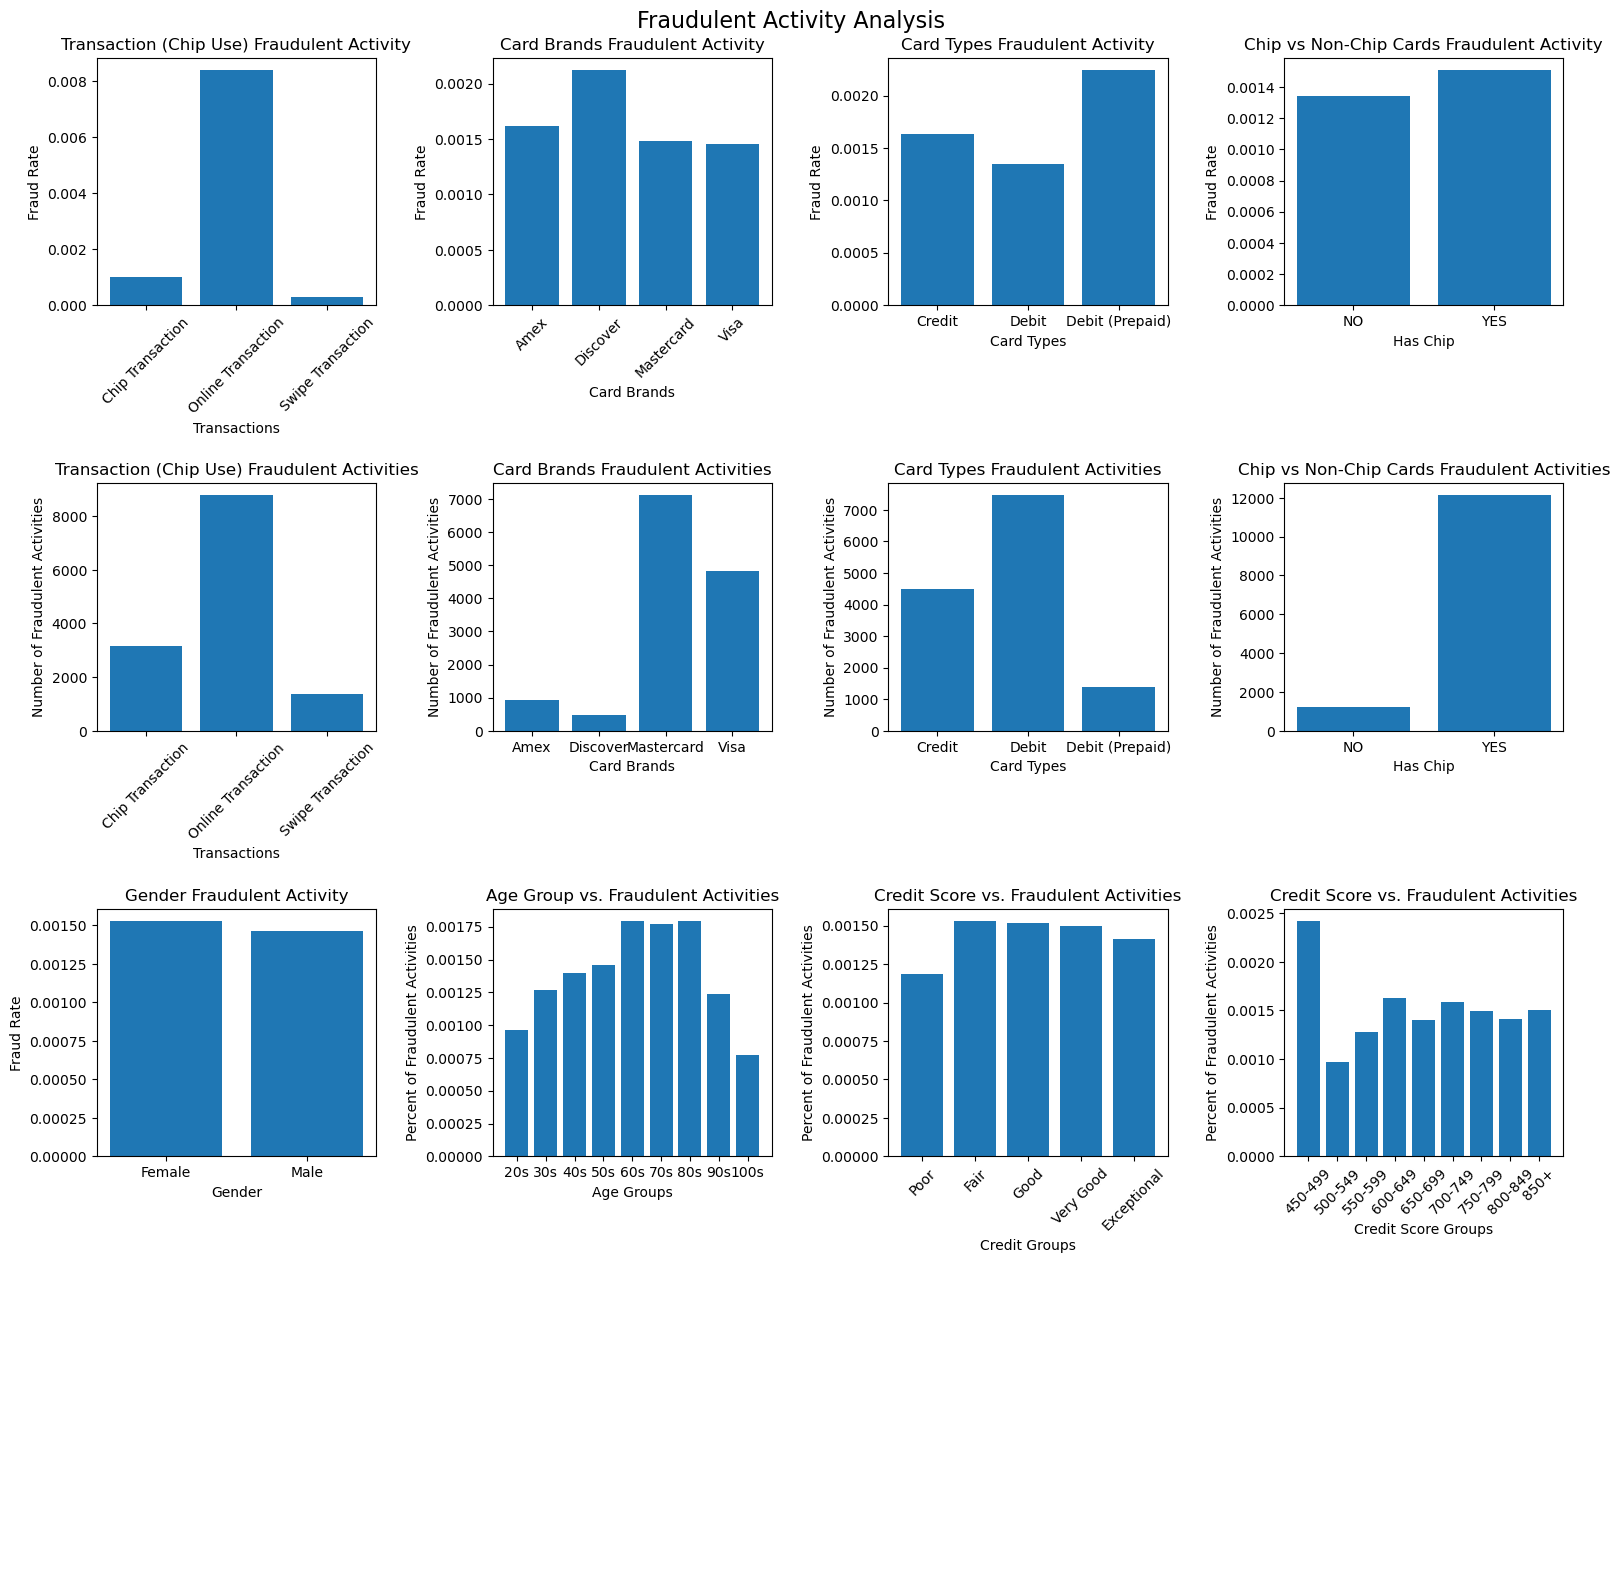

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))  # Adjust size as needed

# Transaction (Chip Use) Fraudulent Activity - Fraud Rate
axes[0, 0].bar(tfmcu.groupby("use_chip")["fraud_binary"].mean().index,
               tfmcu.groupby("use_chip")["fraud_binary"].mean())
axes[0, 0].set_xlabel('Transactions')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].set_ylabel('Fraud Rate')
axes[0, 0].set_title('Transaction (Chip Use) Fraudulent Activity')

# Card Brand Fraudulent Activity - Fraud Rate
axes[0, 1].bar(tfmcu.groupby("card_brand")["fraud_binary"].mean().index,
               tfmcu.groupby("card_brand")["fraud_binary"].mean())
axes[0, 1].set_xlabel('Card Brands')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylabel('Fraud Rate')
axes[0, 1].set_title('Card Brands Fraudulent Activity')

# Card Type Fraudulent Activity - Fraud Rate
axes[0, 2].bar(tfmcu.groupby("card_type")["fraud_binary"].mean().index,
               tfmcu.groupby("card_type")["fraud_binary"].mean())
axes[0, 2].set_xlabel('Card Types')
axes[0, 2].set_ylabel('Fraud Rate')
axes[0, 2].set_title('Card Types Fraudulent Activity')

# Has Chip Fraudulent Activity - Fraud Rate
axes[0, 3].bar(tfmcu.groupby("has_chip")["fraud_binary"].mean().index,
               tfmcu.groupby("has_chip")["fraud_binary"].mean())
axes[0, 3].set_xlabel('Has Chip')
axes[0, 3].set_ylabel('Fraud Rate')
axes[0, 3].set_title('Chip vs Non-Chip Cards Fraudulent Activity')

# Transaction (Chip Use) Fraudulent Activities - Number of Frauds
axes[1, 0].bar(tfmcu.groupby("use_chip")["fraud_binary"].sum().index,
               tfmcu.groupby("use_chip")["fraud_binary"].sum())
axes[1, 0].set_xlabel('Transactions')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].set_ylabel('Number of Fraudulent Activities')
axes[1, 0].set_title('Transaction (Chip Use) Fraudulent Activities')

# Card Brand Fraudulent Activities - Number of Frauds
axes[1, 1].bar(tfmcu.groupby("card_brand")["fraud_binary"].sum().index,
               tfmcu.groupby("card_brand")["fraud_binary"].sum())
axes[1, 1].set_xlabel('Card Brands')
axes[1, 1].set_ylabel('Number of Fraudulent Activities')
axes[1, 1].set_title('Card Brands Fraudulent Activities')

# Card Type Fraudulent Activities - Number of Frauds
axes[1, 2].bar(tfmcu.groupby("card_type")["fraud_binary"].sum().index,
               tfmcu.groupby("card_type")["fraud_binary"].sum())
axes[1, 2].set_xlabel('Card Types')
axes[1, 2].set_ylabel('Number of Fraudulent Activities')
axes[1, 2].set_title('Card Types Fraudulent Activities')

# Has Chip Fraudulent Activities - Number of Frauds
axes[1, 3].bar(tfmcu.groupby("has_chip")["fraud_binary"].sum().index,
               tfmcu.groupby("has_chip")["fraud_binary"].sum())
axes[1, 3].set_xlabel('Has Chip')
axes[1, 3].set_ylabel('Number of Fraudulent Activities')
axes[1, 3].set_title('Chip vs Non-Chip Cards Fraudulent Activities')

# Gender Fraudulent Activity - Fraud Rate
axes[2, 0].bar(tfmcu.groupby("gender")["fraud_binary"].mean().index,
               tfmcu.groupby("gender")["fraud_binary"].mean())
axes[2, 0].set_xlabel('Gender')
axes[2, 0].set_ylabel('Fraud Rate')
axes[2, 0].set_title('Gender Fraudulent Activity')

# Age Group Fraudulent Activity - Fraud Rate
age_bins = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
age_labels = ['10s', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s', '100s']
tfmcu["age_group"] = pd.cut(tfmcu["current_age"], bins=age_bins, labels=age_labels, right=False)
age_grouped = tfmcu.groupby("age_group", observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
axes[2, 1].bar(age_grouped['age_group'], age_grouped['fraud_rate'])
axes[2, 1].set_xlabel('Age Groups')
axes[2, 1].set_ylabel('Percent of Fraudulent Activities')
axes[2, 1].set_title('Age Group vs. Fraudulent Activities')

# Credit Group Fraudulent Activity - Fraud Rate 
credit_bins = [300, 580, 670, 740, 800, 850]
credit_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Exceptional']
tfmcu["credit_group"] = pd.cut(tfmcu["credit_score"], bins=credit_bins, labels=credit_labels, right=False)
credit_grouped = tfmcu.groupby("credit_group", observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
axes[2, 2].bar(credit_grouped['credit_group'], credit_grouped['fraud_rate'])
axes[2, 2].set_xlabel('Credit Groups')
axes[2, 2].tick_params(axis='x', rotation=45)
axes[2, 2].set_ylabel('Percent of Fraudulent Activities')
axes[2, 2].set_title('Credit Score vs. Fraudulent Activities')

# Credit Score Group Fraudulent Activity - Fraud Rate 
credit_bins = [450, 500, 550, 600, 650, 700, 750, 800, 850, 900]
credit_labels = ['450-499', '500-549', '550-599', '600-649', '650-699', '700-749', '750-799', '800-849', '850+']
tfmcu["credit_score_group"] = pd.cut(tfmcu["credit_score"], bins=credit_bins, labels=credit_labels, right=False)
credit_score_grouped = tfmcu.groupby("credit_score_group", observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
axes[2, 3].bar(credit_score_grouped["credit_score_group"], credit_score_grouped['fraud_rate'])
axes[2, 3].set_xlabel('Credit Score Groups')
axes[2, 3].tick_params(axis='x', rotation=45)
axes[2, 3].set_ylabel('Percent of Fraudulent Activities')
axes[2, 3].set_title('Credit Score vs. Fraudulent Activities')

# Optional plots 
axes[3, 0].axis('off')
axes[3, 1].axis('off')
axes[3, 2].axis('off')
axes[3, 3].axis('off')

# Adjust layout and display
plt.tight_layout(pad=2.0)  # Adjust padding between subplots for better spacing
plt.suptitle('Fraudulent Activity Analysis', fontsize=16, y = 1)  # Set a main title for the entire figure
plt.show()

In [23]:
tfmcu.to_csv('output2.csv', index=False)

### Engineered Data

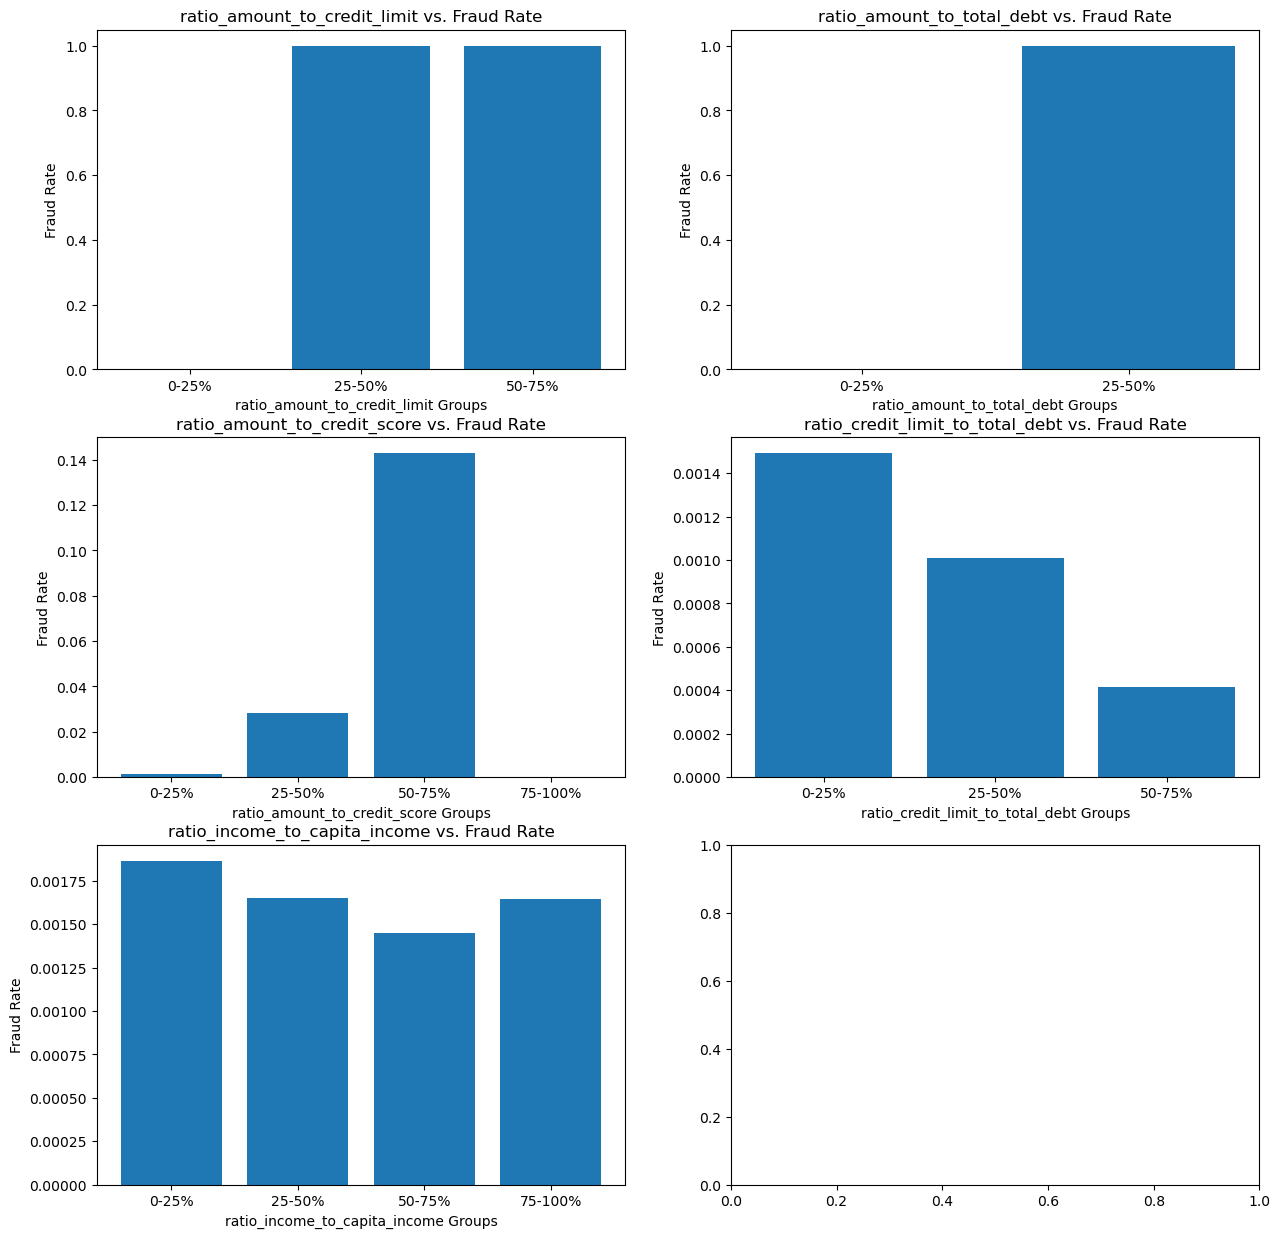

In [25]:
import matplotlib.pyplot as plt

ratio_columns = [
    "ratio_amount_to_credit_limit",
    "ratio_amount_to_total_debt",
    "ratio_amount_to_credit_score",
    "ratio_credit_limit_to_total_debt",
    "ratio_income_to_capita_income"
]

# Function to automate graph creation
def automate_graphs(data, ratio_columns):
    # Setting up the plot grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # Adjust grid size based on the number of plots
    axes = axes.flatten()  # Flatten for easy iteration

    for i, column in enumerate(ratio_columns):
        if i >= len(axes):  # Avoid errors if too many columns
            break

        # Calculate the min and max
        min_val = data[f'{column}'].min()
        max_val = data[f'{column}'].max()
        
        # Create 4 sections (quartiles)
        column_bins = [min_val, 
                min_val + (max_val - min_val) * 0.25, 
                min_val + (max_val - min_val) * 0.5, 
                min_val + (max_val - min_val) * 0.75, 
                max_val]
        
        # Generate the data for each column
        #column_bins = [0, 0.25, 0.5, 0.75, 1.0]  # Customize bin ranges if needed
        column_labels = ['0-25%', '25-50%', '50-75%', '75-100%']
        data[f"{column}_group"] = pd.cut(data[column], bins=column_bins, labels=column_labels, right=False)
        grouped_data = data.groupby(f"{column}_group",observed=True)["fraud_binary"].mean().reset_index(name="fraud_rate")
        
        # Create the bar plot
        ax = axes[i]
        ax.bar(grouped_data[f"{column}_group"].astype(str), grouped_data["fraud_rate"])
        ax.set_xlabel(f'{column} Groups')
        ax.set_ylabel('Fraud Rate')
        ax.set_title(f'{column} vs. Fraud Rate')

# Usage
automate_graphs(tfmcu, ratio_columns)


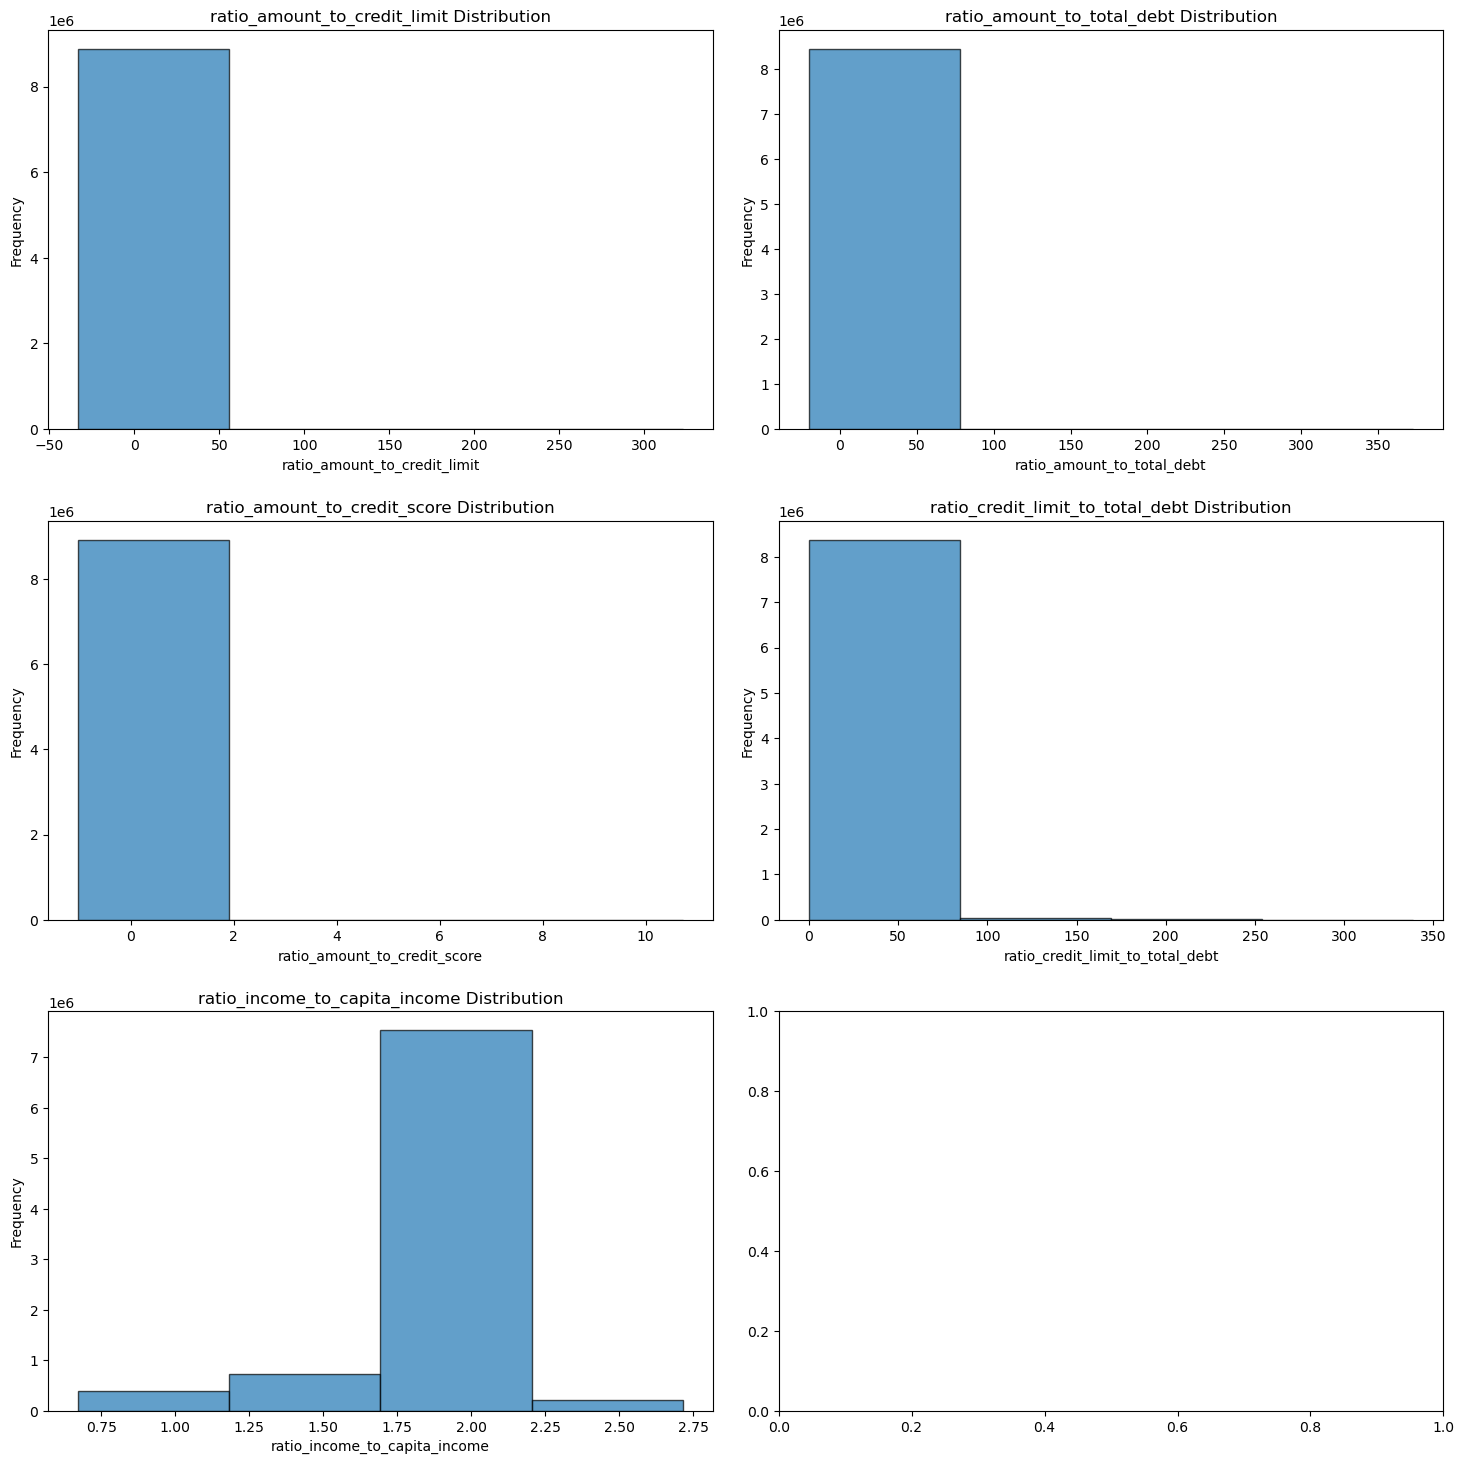

In [26]:
import matplotlib.pyplot as plt

ratio_columns = [
    "ratio_amount_to_credit_limit",
    "ratio_amount_to_total_debt",
    "ratio_amount_to_credit_score",
    "ratio_credit_limit_to_total_debt",
    "ratio_income_to_capita_income"
]

# Function to automate histogram creation
def automate_histograms(data, ratio_columns):
    # Setting up the plot grid
    fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))  # Adjust grid size based on the number of plots
    axes = axes.flatten()  # Flatten for easy iteration

    for i, column in enumerate(ratio_columns):
        if i >= len(axes):  # Avoid errors if too many columns
            break

        # Create the histogram for each ratio column
        ax = axes[i]
        ax.hist(data[column], bins=4, edgecolor='black', alpha=0.7)
        
        ax.set_xlabel(f'{column}')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{column} Distribution')

    # Adjust layout for better spacing
    plt.tight_layout(pad=2.0)
    plt.show()

# Usage
automate_histograms(tfmcu, ratio_columns)


<Axes: xlabel='credit_group', ylabel='age_group'>

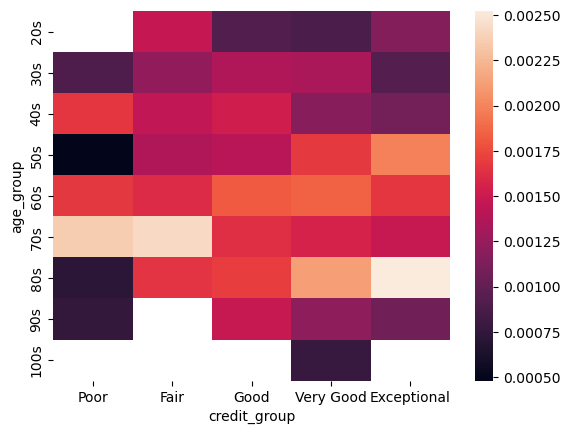

In [27]:
age_v_credit = pd.crosstab(tfmcu["age_group"],tfmcu["credit_group"], values = tfmcu["fraud_binary"],aggfunc = "mean")
sns.heatmap(age_v_credit)

In [90]:
#Correlation for subset of dataframe

corr = tfmcu_sub.corr(method = 'pearson')
corr

,amount,merchant_id,mcc,fraud_binary,has_chip_binary,num_cards_issued,credit_limit,year_pin_last_changed,current_age,retirement_age,...,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards,ratio_amount_to_credit_limit,ratio_amount_to_total_debt,ratio_amount_to_credit_score,ratio_credit_limit_to_total_debt,ratio_income_to_capita_income
amount,1.000000,-0.014304,-0.033217,0.031940,0.001276,-0.000289,0.068618,0.006759,-0.004277,-0.005131,...,0.103255,0.103494,0.045200,-0.013532,-0.006629,0.054685,0.056289,0.993058,-0.012005,0.008916
merchant_id,-0.014304,1.000000,0.076912,0.005827,-0.001621,-0.000725,-0.004106,0.002021,0.005886,-0.001779,...,-0.007780,-0.005422,0.002073,0.003394,0.039669,0.000110,-0.003405,-0.014556,-0.016201,0.010001
mcc,-0.033217,0.076912,1.000000,-0.015118,-0.015765,0.006175,-0.013365,0.002024,0.006614,0.006332,...,-0.018294,-0.014941,-0.003950,0.014685,0.013702,-0.000388,-0.001708,-0.034206,-0.019268,0.009827
fraud_binary,0.031940,0.005827,-0.015118,1.000000,0.001301,-0.000108,-0.005706,0.000152,0.004423,0.000567,...,-0.002882,-0.003642,-0.003211,0.000827,0.006799,0.034368,0.013284,0.031413,-0.000984,-0.002264
has_chip_binary,0.001276,-0.001621,-0.015765,0.001301,1.000000,0.011237,-0.007638,0.016499,-0.010542,-0.000451,...,-0.020137,-0.032443,-0.005320,-0.009517,-0.011449,-0.000022,-0.000281,0.002170,-0.003401,-0.034785
num_cards_issued,-0.000289,-0.000725,0.006175,-0.000108,0.011237,1.000000,-0.067989,0.041302,0.015334,-0.063372,...,0.010404,0.006875,0.018138,-0.075690,-0.084882,0.000128,0.001796,0.003604,-0.020126,-0.012359
credit_limit,0.068618,-0.004106,-0.013365,-0.005706,-0.007638,-0.067989,1.000000,-0.038900,-0.035974,0.014058,...,0.608114,0.577104,0.291643,0.021831,0.067418,-0.113702,-0.007589,0.065759,0.074065,0.017907
year_pin_last_changed,0.006759,0.002021,0.002024,0.000152,0.016499,0.041302,-0.038900,1.000000,-0.030288,0.006921,...,0.002680,0.007894,0.013514,-0.007491,0.000390,0.017934,-0.000274,0.006894,-0.004543,0.012461
current_age,-0.004277,0.005886,0.006614,0.004423,-0.010542,0.015334,-0.035974,-0.030288,1.000000,-0.008016,...,0.010588,-0.120399,-0.406826,-0.019262,0.388283,0.013400,0.050224,-0.002075,0.300151,-0.481491
retirement_age,-0.005131,-0.001779,0.006332,0.000567,-0.000451,-0.063372,0.014058,0.006921,-0.008016,1.000000,...,-0.041218,-0.004091,-0.013339,0.163962,0.151124,-0.010180,0.020864,-0.013570,0.069433,0.121291


In [74]:
from sklearn.utils import resample
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

def balance_dataset(data, target_column, method='undersample', random_state=42):
    """
    Balance a dataset using undersampling or oversampling.
    
    Parameters:
        data (pd.DataFrame): The dataset to balance.
        target_column (str): The name of the target column.
        method (str): 'undersample', 'oversample', or 'smote'.
        random_state (int): Random seed for reproducibility.
    
    Returns:
        pd.DataFrame: A balanced dataset.
    """
    X = data.drop(columns=[target_column])  # Features
    y = data[target_column]  # Target
    
    if method == 'undersample':
        # Using RandomUnderSampler
        rus = RandomUnderSampler(random_state=random_state)
        X_resampled, y_resampled = rus.fit_resample(X, y)
        
    elif method == 'oversample':
        # Using RandomOverSampler
        ros = RandomOverSampler(random_state=random_state)
        X_resampled, y_resampled = ros.fit_resample(X, y)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE(random_state=random_state)
        X_resampled, y_resampled = smote.fit_resample(X, y)
    
    else:
        raise ValueError("Method must be 'undersample', 'oversample', or 'smote'.")
    
    # Combine resampled features and target into a single DataFrame
    balanced_data = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=[target_column])], axis=1)
    return balanced_data


In [76]:
balanced_data = balance_dataset(tfmcu_sub, target_column='fraud_binary', method='undersample')
print(balanced_data['fraud_binary'].value_counts())

fraud_binary
0    13332
1    13332
Name: count, dtype: int64


Accuracy: 0.763125
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.78      0.77      3991
           1       0.77      0.75      0.76      4009

    accuracy                           0.76      8000
   macro avg       0.76      0.76      0.76      8000
weighted avg       0.76      0.76      0.76      8000



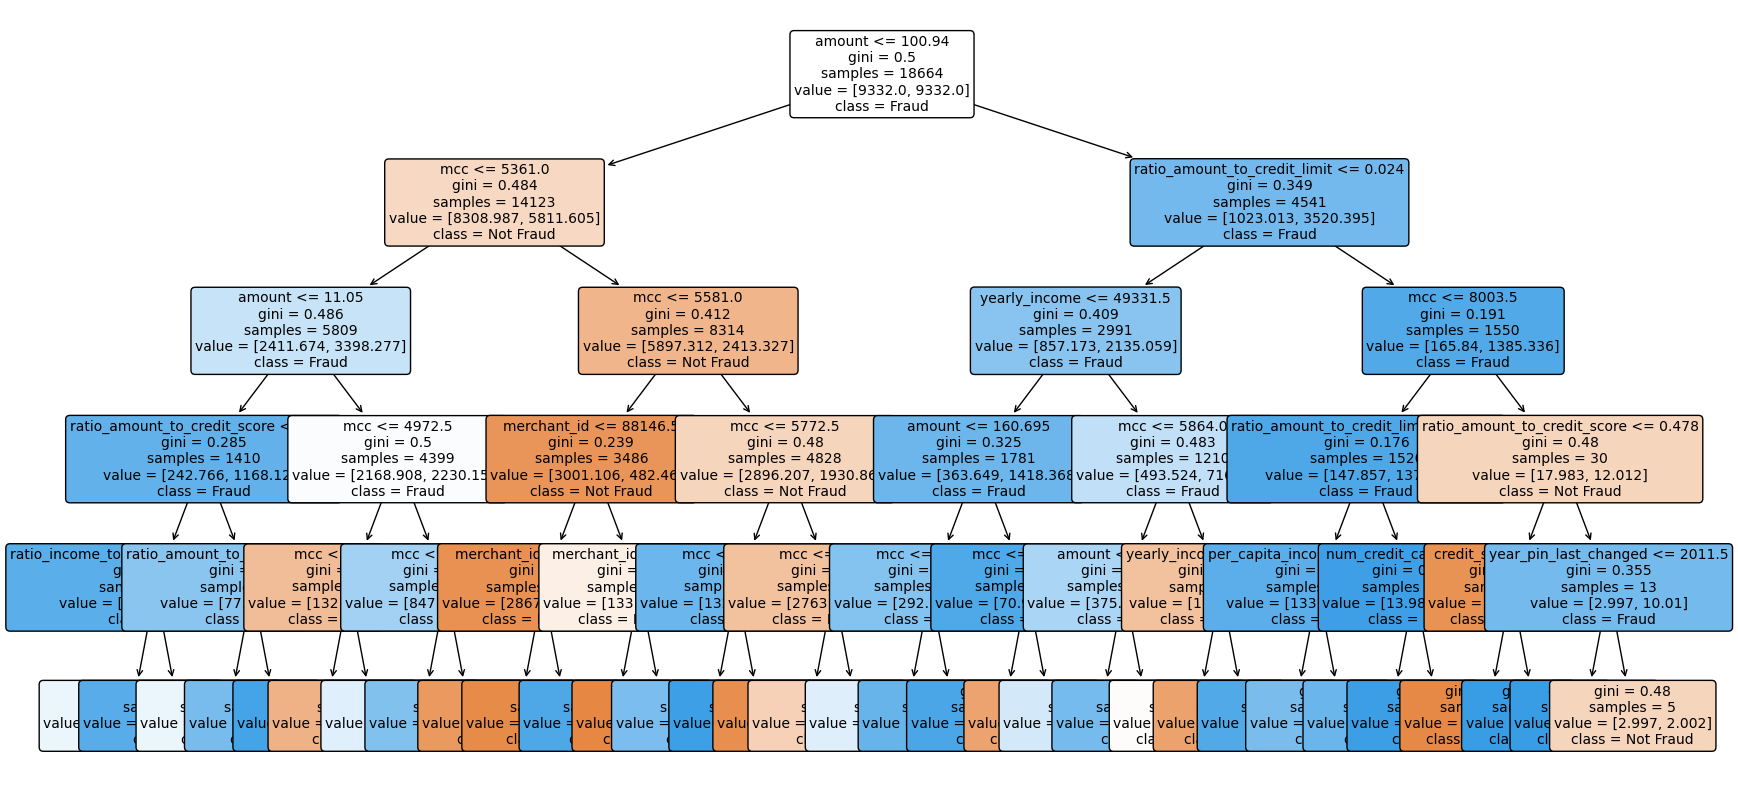

In [88]:
# Step 1: Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

from sklearn import tree
import matplotlib.pyplot as plt


# Step 2: Load your dataset - 'fraud_binary' is the target variable and other columns are features
X = balanced_data.drop(columns=["fraud_binary"])  # Feature columns
y = balanced_data["fraud_binary"]  # Target column (fraud binary)

# Step 3: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 4: Create and train the Decision Tree model
clf = DecisionTreeClassifier(max_depth = 5, class_weight = 'balanced', random_state=42)
clf.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = clf.predict(X_test)

# Step 6: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 7: Visualize the Decision Tree
plt.figure(figsize=(20, 10))  # Increase the figure size for better visibility
plot_tree(
    clf, 
    feature_names=X_train.columns,  # Replace with your feature names
    class_names=["Not Fraud", "Fraud"],  # Replace with your class names
    filled=True, 
    rounded=True, 
    fontsize=10  # Adjust font size for readability
)
plt.show()



In [30]:
print(y_pred.sum())
print(y_pred.shape)

458982
(2674489,)


In [94]:
## Logistic regression 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

balanced_data = balanced_data.dropna()
X = balanced_data.drop('fraud_binary', axis=1)  # Drop the target column to get the features
y = balanced_data['fraud_binary']  # The target column (binary 0 or 1)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
log_reg = LogisticRegression(C=0.1, penalty='l2', solver='lbfgs', max_iter = 10, random_state=42)
log_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = log_reg.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{report}')
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.5479863754758565
Classification Report: 
              precision    recall  f1-score   support

           0       0.57      0.50      0.53      2554
           1       0.53      0.60      0.56      2437

    accuracy                           0.55      4991
   macro avg       0.55      0.55      0.55      4991
weighted avg       0.55      0.55      0.55      4991

Confusion Matrix: 
[[1270 1284]
 [ 972 1465]]


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
## Random Forest 
# Import necessary libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

X = tfmcu_sub.drop('fraud_binary', axis=1)  # Drop the target column to get the features
y = tfmcu_sub['fraud_binary']  # The target column (binary 0 or 1)

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest model
rf_reg = RandomForestRegressor(n_estimators=20, random_state=42)
rf_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_reg.predict(X_test)

# Evaluate the model performance
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mse_rf ** 0.5
r2_rf = r2_score(y_test, y_pred_rf)

# Print the results
print(f'Mean Squared Error (MSE) - Random Forest: {mse_rf}')
print(f'Root Mean Squared Error (RMSE) - Random Forest: {rmse_rf}')
print(f'R-squared (R2) - Random Forest: {r2_rf}')


Mean Squared Error (MSE) - Random Forest: 0.0011965741050017607
Root Mean Squared Error (RMSE) - Random Forest: 0.034591532273112166
R-squared (R2) - Random Forest: 0.18943774938945956


### Tolerancing/ Thresholding (False Positive, False Negatives)

In [ ]:

#sklearn metrics library 

TP = 0.38 #true positive
TN = 0 #true negative
FP = 0.62 #false positive 
FN = 0 #false negative

threshold_high = 0.9
threshold_mid = 0.5
threshold_low = 0.2

precision = TP / (TP + FP)
recall = TP/ (TP + FN) 

print(precision)
print(recall)

# adaptive thresholds
# severity weighting - high value transactions have lower threshold

## Step 4: Analysis Insights

blah blah 